# Lab 4 : Evaluation and Multi-Layer Perceptron
##### By Liam Lowsley-Williams, Eli Laird, Fernando Vazquez

In [20]:
import pandas as pd
import numpy as np
import cv2
import os

# plotly
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Marker, Layout, Bar, Line
from plotly.graph_objs.layout import XAxis, YAxis
plotly.offline.init_notebook_mode()

# matplotlib
%matplotlib inline 
from matplotlib import pyplot as plt

## Business Understanding

[5 points] (mostly the same processes as from previous lab) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

### Motivation

- motivation here

### Objectives

- objectives here

## Data Preparation

### Loading in the data

Below we load in our image data. As you can see we load in the train and the test data and then combine the two into one master numpy array. After loading, we have an images array that contains the image data, a labels_ext array which contains tuples of each image's filename and it's coressponding class, and a labels array which records ONLY what each image is classified as (index locations in the images array map to index locations in the labels array).

However, it should be noted that for our data set the pre-processing was already done for an Intel competition. The data was split into ~14k images in train, ~3k in test, and ~7k in prediction. We merged the two train and test as mentioned above to get a dataset size of ~17k images, all 150x150px. The predicition dataset was unable to be included as there were no associated classifications to it's data.

In [2]:
file_path_train = './data/images/seg_train'
file_path_test = './data/images/seg_test'
directory_dir_train = os.listdir(file_path_train)
directory_dir_test = os.listdir(file_path_test)
# Mac -- remove .DS_Store if its there.
try:
    directory_dir_train.remove('.DS_Store')
    directory_dir_test.remove('.DS_Store')
except:
    print("Did not find and remove a .DS_Store in train/test")

#read in images
images_raw = []
labels_ext = []
error_count = 0
wrong_size = 0

# FOR TRAIN SET
for directory in directory_dir_train:
    for img in os.listdir(file_path_train + '/' + directory):
        image = cv2.imread(file_path_train + '/' + directory + '/' + img, cv2.IMREAD_GRAYSCALE)
        try:
            flat_img = image.flatten()
            if(flat_img.size == 22500):
                images_raw.append(flat_img)
                labels_ext.append((directory,img))
            else:
                wrong_size += 1
        except:
            error_count += 1

# FOR TEST SET
for directory in directory_dir_test:
    for img in os.listdir(file_path_test + '/' + directory):
        image = cv2.imread(file_path_test + '/' + directory + '/' + img, cv2.IMREAD_GRAYSCALE)
        try:
            flat_img = image.flatten()
            if(flat_img.size == 22500):
                images_raw.append(flat_img)
                labels_ext.append((directory,img))
            else:
                wrong_size += 1
        except:
            error_count += 1

# create our variables for images and labels
images = np.array(images_raw)
labels_ext = np.array(labels_ext)
labels = [i[0] for i in labels_ext]

# specify height and width
h, w = (150,150)

print("{} Images failed to resize".format(error_count))
print("{} Images were corrupt/wrong size".format(wrong_size))
print("Image size:", images[0].shape)
print("Image Count:", len(images))

0 Images failed to resize
55 Images were corrupt/wrong size
Image size: (22500,)
Image Count: 16979


In [3]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery(images, title, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = random.sample(range(0,images.shape[0]), k=18)
    for n,i in enumerate(rand_sample):
        plt.subplot(n_row, n_col, n + 1)
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(title[i], size=12)
        plt.xticks(())
        plt.yticks(())

Below is a sample plot of 18 images (in grayscale) from the dataset

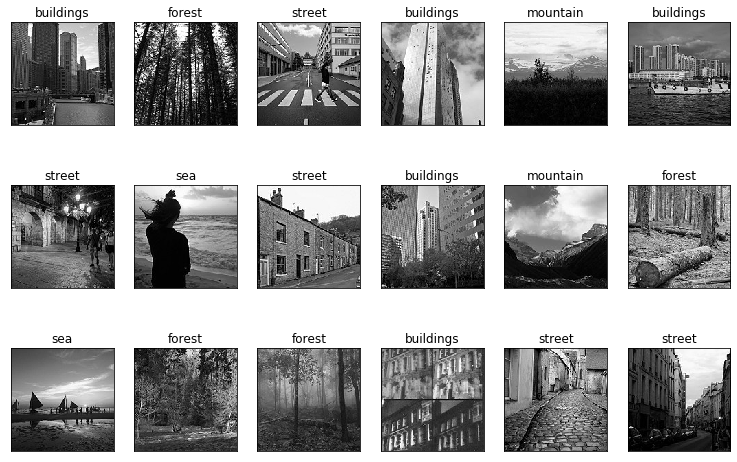

In [4]:
# plot images
plot_gallery(images, labels, h, w)

### Data Cleaning

Due to the vast size of our data set, we decided to sample a subset of each class. The data set contained between 2628-3037 instances per class as you can see depicted in the table and chart below. We decided that it was acceptable to take random sample of 1000 instances of each class to use for our dataset. This way we get an equalized number of instances per class which may help improve our training metric.

In [5]:
df_labels = pd.DataFrame(labels_ext, columns =['Class', 'Name']) 

df_labels_count = df_labels['Class'].value_counts().reset_index()
df_labels_count.columns = ['Class', 'Count']
df_labels_count

Class  Count
0   mountain   3018
1    glacier   2936
2     street   2882
3        sea   2780
4     forest   2736
5  buildings   2627

In [6]:
fig = go.Figure([go.Bar(x=df_labels_count['Class'], y=df_labels_count['Count'])])

fig.update_layout(
    title = 'Counts of Unique Classes In DataSet',
)
fig.show()

In [7]:
df_forest = df_labels.loc[df_labels['Class'] == 'forest']
df_mountain = df_labels.loc[df_labels['Class'] == 'mountain']
df_glacier = df_labels.loc[df_labels['Class'] == 'glacier']
df_street = df_labels.loc[df_labels['Class'] == 'street']
df_sea = df_labels.loc[df_labels['Class'] == 'sea']
df_buildings = df_labels.loc[df_labels['Class'] == 'buildings']

pd_labels_sample = pd.concat([
    df_forest['Name'].sample(n=1000),
    df_mountain['Name'].sample(n=1000),
    df_glacier['Name'].sample(n=1000),
    df_street['Name'].sample(n=1000),
    df_sea['Name'].sample(n=1000),
    df_buildings['Name'].sample(n=1000)
])

labels_sample = pd_labels_sample.values
labels_sample

array(['9944.jpg', '10294.jpg', '15301.jpg', ..., '15699.jpg', '8418.jpg',
       '21599.jpg'], dtype=object)

Here we selected the 1000 image sample from each class

In [8]:
images

array([[ 45,  66,  86, ...,  35,  28,  38],
       [ 40, 120, 126, ...,   6,   5,  10],
       [ 46, 176,  71, ...,  47,  35,  41],
       ...,
       [229, 229, 228, ..., 113, 116, 120],
       [115, 109, 103, ..., 123, 190, 189],
       [193, 192, 193, ...,  63,  34,  43]], dtype=uint8)

In [9]:
df_images_labels = pd.DataFrame(data=[
    df_labels['Name'].values, 
    df_labels['Class'].values, 
    images
]).T
df_images_labels

0       1                                                  2
0       5109.jpg  forest  [45, 66, 86, 138, 104, 95, 168, 183, 163, 168,...
1      14621.jpg  forest  [40, 120, 126, 144, 244, 202, 154, 172, 2, 13,...
2       6366.jpg  forest  [46, 176, 71, 83, 122, 117, 84, 96, 80, 107, 1...
3       4565.jpg  forest  [9, 10, 10, 9, 8, 7, 8, 9, 5, 5, 5, 5, 5, 5, 6...
4      17472.jpg  forest  [44, 30, 88, 145, 138, 144, 128, 171, 104, 135...
...          ...     ...                                                ...
16974  21481.jpg     sea  [124, 127, 128, 127, 129, 134, 135, 132, 131, ...
16975  24076.jpg     sea  [89, 88, 88, 88, 88, 87, 86, 85, 84, 87, 88, 8...
16976  23725.jpg     sea  [229, 229, 228, 228, 228, 228, 228, 228, 227, ...
16977  21898.jpg     sea  [115, 109, 103, 103, 138, 152, 145, 122, 114, ...
16978  23731.jpg     sea  [193, 192, 193, 195, 199, 201, 202, 201, 201, ...

[16979 rows x 3 columns]

In [10]:
images_sample = df_images_labels.loc[
    df_images_labels[0].isin(labels_sample)
].reset_index(drop=True)

images_sample.columns = ['name', 'class', 'image']
images_sample

name   class                                              image
0     14621.jpg  forest  [40, 120, 126, 144, 244, 202, 154, 172, 2, 13,...
1     17472.jpg  forest  [44, 30, 88, 145, 138, 144, 128, 171, 104, 135...
2      9096.jpg  forest  [56, 51, 188, 182, 156, 78, 92, 80, 55, 41, 59...
3     16977.jpg  forest  [6, 8, 146, 249, 0, 87, 159, 154, 149, 7, 115,...
4     14423.jpg  forest  [25, 21, 47, 2, 16, 31, 34, 49, 62, 75, 110, 6...
...         ...     ...                                                ...
5995  24301.jpg     sea  [142, 152, 143, 149, 143, 147, 149, 146, 151, ...
5996  20167.jpg     sea  [123, 124, 125, 126, 127, 128, 129, 130, 128, ...
5997  23679.jpg     sea  [230, 230, 229, 229, 229, 229, 230, 230, 229, ...
5998  24274.jpg     sea  [75, 75, 75, 75, 75, 75, 74, 74, 74, 74, 74, 7...
5999  24076.jpg     sea  [89, 88, 88, 88, 88, 87, 86, 85, 84, 87, 88, 8...

[6000 rows x 3 columns]

As you can see we have here our dataframe that contains 1000 instances per class for a total of 6000 instances.

In [11]:
# select random images to visualize
import random
random.seed(1)

# function to plot images in grid like fashion
def plot_gallery_df(images_df, title_col, image_col, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    rand_sample = images_df.sample(n = 18)
    count = 0
    for index, row in rand_sample.iterrows():
        plt.subplot(n_row, n_col, count + 1)
        count = count + 1
        plt.imshow(row[image_col].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(row[title_col], size=12)
        plt.xticks(())
        plt.yticks(())

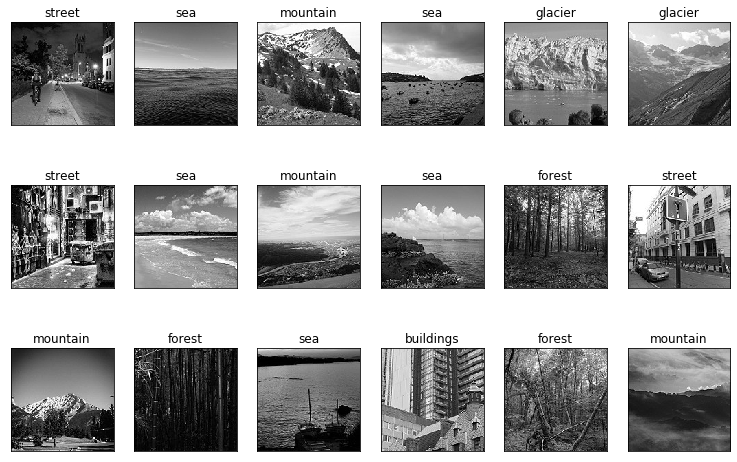

In [12]:
# plot images
plot_gallery_df(images_sample, 'class', 'image', 150, 150)

### PCA Dimensionality Reduction

We will also use PCA to perform dimensionality reduction on our images. This will help speed up the neural network when training and wont damage our metric for performance by too much. As seen below, we were able to reduce the size of a flattened image from 22,500 to 4,000 and still have a 98.7% explained variance ratio. 

In [21]:
from sklearn.decomposition import PCA

def plot_explained_variance(pca):
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    fig_pca = go.Figure([
        go.Bar(y=explained_var, name='individual explained variance'), 
        go.Scatter(y=cum_var_exp, name='cumulative explained variance'),

    ])

    fig_pca.update_layout(
        title = 'Counts of Unique Classes In DataSet',
        xaxis = XAxis(title='Principal components'), 
        yaxis = YAxis(title='Explained variance ratio')
    )
    fig_pca.show()

In [14]:
# re-convert to a numpy matrix (dont ask me why this is neccesary but i probably messed something up)
images_dim = []
for img in images_sample['image'].values:
    images_dim.append(img)
images_dim = np.array(images_dim)

pca = PCA(n_components=4000)
pca_fit = pca.fit_transform(images_dim)

In [22]:
plot_explained_variance(pca)

In [23]:
pca_fit.shape

(6000, 4000)

In [24]:
pca_fit

array([[-6.19535948e+03, -1.61754042e+03,  6.76914258e+02, ...,
        -3.34737566e+01, -1.63848568e+01,  6.50014112e+00],
       [ 1.62623798e+02,  3.87467919e+03,  9.33235151e+02, ...,
        -4.20403530e+01, -4.23575256e+00, -5.27547717e+01],
       [-2.66140190e+03, -2.59183063e+03,  1.50671736e+02, ...,
         1.67773491e+01, -8.25961071e+00,  1.81728349e+01],
       ...,
       [ 8.84723698e+03,  5.66989160e+03,  7.05072299e+03, ...,
         1.69450445e+01, -2.58165756e+01,  4.44283894e+00],
       [-2.87608818e+03,  6.06675922e+03, -1.90178052e+03, ...,
        -4.00381103e+01,  2.64606940e+01,  1.07648133e+01],
       [-3.48528877e+03,  2.85374994e+03, -3.74364973e+03, ...,
         1.32421842e+01,  5.91791561e+00, -2.94623838e+01]])

In [25]:
final_image_set = pd.DataFrame(data=[
    images_sample['class'].values, 
    pca_fit
]).T

final_image_set.columns = ['class', 'image']

In [26]:
final_image_set

class                                              image
0     forest  [-6195.3594794228875, -1617.5404151932091, 676...
1     forest  [162.62379823796712, 3874.6791945210152, 933.2...
2     forest  [-2661.401902570325, -2591.8306266640284, 150....
3     forest  [-4775.942879144814, -904.5503620113867, 2068....
4     forest  [-7942.3727665074375, -3091.887246140298, 439....
...      ...                                                ...
5995     sea  [-2586.525948245465, 2122.689352545873, -763.1...
5996     sea  [-2891.308817256515, -1842.1685659368916, 1253...
5997     sea  [8847.236983896748, 5669.891602212873, 7050.72...
5998     sea  [-2876.088175726119, 6066.7592188100925, -1901...
5999     sea  [-3485.28877350358, 2853.749940861128, -3743.6...

[6000 rows x 2 columns]

To summarize, our final DataSet consists of 6000 instances split evenly accross 6 classes such that there are 1000 instances per class. We have performed dimensionality reduction on the feature data and reduced the feature size of an image from 22,500 to 4,000. This is the DataSet that we will use for our train-test split.

## Evaluation

#### Metrics

[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why does the metric evaluate performance in terms of the business case you argued for. Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


#### Train-Test Splitting

<b>[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince the reader that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
- Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. </b>


We chose to use stratified shuffle split to split our data into a train set, test set, and validation set. The reason we chose to use stratified shuffle split is because our dataset is quite small. Using SSS we are able to maintain an equal number classes per dataset split. This is further clarified below but essentially means the counts of images in each class (in let's say the training dataset) are the same. This will help the neural network to train more evenly across the different classes which in turn should improve our metric for performance and prevent bias<b>(! ? !)</b>.

After the first split, the training dataset contains 80% of the 6000 instances or 4800 (as seen below) and the test and validation datasets make up the other 20% of the 6000 instances or 1200. 

After the second split, the test and validation datasets were split from the 20% in half as seen below. This resulted in the test and validation datasets having 600 instances each or 10% of our 6000 instance dataset.

Overall, we end up with 3 datasets that contain equal numbers of images per class accross the individual dataset. The sizes for those datasets can be seen below.

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score

# get train and test split
split_train = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_train.split(images_sample, images_sample['class']):
    train_set = images_sample.loc[train_index].reset_index(drop=True)
    test_valid_set = images_sample.loc[test_index].reset_index(drop=True)

# get test and validation split
split_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=65)
for train_index, test_index in split_test.split(test_valid_set, test_valid_set['class']):
    test_set = test_valid_set.loc[train_index].reset_index(drop=True)
    validation_set = test_valid_set.loc[test_index].reset_index(drop=True)

print("Shape of Train Set: {}".format(train_set.shape))
print("Shape of Test Set: {}".format(test_set.shape))
print("Shape of Validation Set: {}".format(validation_set.shape))

Shape of Train Set: (4800, 3)
Shape of Test Set: (600, 3)
Shape of Validation Set: (600, 3)


In [28]:
train_set

name      class                                              image
0      8797.jpg  buildings  [147, 149, 145, 144, 131, 146, 143, 147, 138, ...
1     17615.jpg     street  [92, 101, 100, 79, 56, 60, 58, 38, 80, 25, 42,...
2     18267.jpg     forest  [179, 106, 117, 120, 204, 152, 100, 94, 126, 8...
3      3661.jpg     street  [141, 139, 139, 141, 142, 140, 140, 142, 140, ...
4      9926.jpg     street  [12, 1, 0, 16, 13, 0, 10, 1, 67, 20, 41, 41, 6...
...         ...        ...                                                ...
4795  12473.jpg    glacier  [231, 231, 232, 232, 233, 233, 233, 234, 232, ...
4796   9840.jpg   mountain  [239, 240, 240, 239, 239, 240, 239, 238, 240, ...
4797  18804.jpg        sea  [115, 79, 37, 36, 146, 76, 73, 82, 2, 21, 37, ...
4798   9434.jpg   mountain  [110, 111, 112, 113, 113, 113, 112, 111, 111, ...
4799    644.jpg    glacier  [238, 237, 237, 236, 237, 237, 238, 238, 238, ...

[4800 rows x 3 columns]

In [29]:
test_set

name      class                                              image
0     3375.jpg    glacier  [143, 143, 143, 143, 143, 144, 144, 145, 145, ...
1      463.jpg  buildings  [40, 40, 40, 41, 41, 41, 41, 41, 41, 40, 40, 4...
2    23065.jpg     forest  [156, 129, 141, 143, 165, 147, 160, 115, 153, ...
3     5750.jpg        sea  [186, 186, 186, 187, 187, 187, 187, 187, 186, ...
4    13201.jpg    glacier  [226, 226, 227, 227, 228, 228, 229, 229, 231, ...
..         ...        ...                                                ...
595  10950.jpg        sea  [190, 191, 192, 193, 194, 195, 195, 195, 194, ...
596  17930.jpg     forest  [45, 1, 123, 232, 191, 112, 64, 18, 13, 144, 1...
597    206.jpg        sea  [235, 235, 234, 236, 239, 228, 238, 239, 236, ...
598  19743.jpg     street  [1, 86, 111, 11, 19, 14, 2, 35, 31, 36, 21, 16...
599  23632.jpg     forest  [116, 148, 133, 43, 41, 40, 41, 44, 36, 95, 82...

[600 rows x 3 columns]

In [30]:
validation_set

name      class                                              image
0     4548.jpg    glacier  [75, 74, 73, 71, 70, 69, 69, 70, 71, 71, 71, 7...
1    19912.jpg   mountain  [227, 225, 225, 227, 228, 228, 231, 235, 234, ...
2     7951.jpg     street  [93, 93, 93, 94, 97, 99, 100, 100, 102, 102, 1...
3    13823.jpg  buildings  [252, 251, 251, 251, 251, 251, 251, 251, 251, ...
4    18305.jpg        sea  [248, 249, 247, 244, 241, 236, 221, 206, 203, ...
..         ...        ...                                                ...
595  22440.jpg        sea  [91, 92, 96, 101, 99, 93, 92, 96, 96, 95, 97, ...
596   8919.jpg     street  [116, 124, 103, 37, 36, 44, 6, 48, 68, 63, 44,...
597   3178.jpg   mountain  [73, 72, 72, 72, 71, 71, 71, 71, 68, 69, 69, 6...
598   2250.jpg     street  [29, 109, 99, 72, 142, 138, 81, 113, 119, 63, ...
599   8029.jpg     street  [89, 93, 86, 93, 87, 7, 5, 7, 8, 18, 30, 40, 2...

[600 rows x 3 columns]

2 channel image is good for PCA, 3 confusing

In [31]:
# dump to pickle
train_set.to_pickle("./data/train.pkl")
test_set.to_pickle("./data/test.pkl")
validation_set.to_pickle("./data/validation.pkl")

In [32]:
# read pickle to pandas
train_set = pd.read_pickle("./data/train.pkl")
test_set = pd.read_pickle("./data/test.pkl")
validation_set = pd.read_pickle("./data/validation.pkl")

In [33]:
train_set

name      class                                              image
0      8797.jpg  buildings  [147, 149, 145, 144, 131, 146, 143, 147, 138, ...
1     17615.jpg     street  [92, 101, 100, 79, 56, 60, 58, 38, 80, 25, 42,...
2     18267.jpg     forest  [179, 106, 117, 120, 204, 152, 100, 94, 126, 8...
3      3661.jpg     street  [141, 139, 139, 141, 142, 140, 140, 142, 140, ...
4      9926.jpg     street  [12, 1, 0, 16, 13, 0, 10, 1, 67, 20, 41, 41, 6...
...         ...        ...                                                ...
4795  12473.jpg    glacier  [231, 231, 232, 232, 233, 233, 233, 234, 232, ...
4796   9840.jpg   mountain  [239, 240, 240, 239, 239, 240, 239, 238, 240, ...
4797  18804.jpg        sea  [115, 79, 37, 36, 146, 76, 73, 82, 2, 21, 37, ...
4798   9434.jpg   mountain  [110, 111, 112, 113, 113, 113, 112, 111, 111, ...
4799    644.jpg    glacier  [238, 237, 237, 236, 237, 237, 238, 238, 238, ...

[4800 rows x 3 columns]